## Deep riccy project

## Colab dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! tar -zxvf /content/drive/MyDrive/Uni/DeepRiccy/refcocog.tar.gz

In [2]:
#set local path to the data

#this is for colab
#local_path = '/content/refcocog/images/'
#local_annotations = '/content/refcocog/annotations/'

#this is for local
local_path = './refcocog/images/' 
local_annotations = './refcocog/annotations/' 

## Dataset

In [30]:
#import section
import json
import pickle
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from pkg_resources import packaging
import clip
import numpy as np



### pandas

In [26]:
class Coco(Dataset):
    def __init__(self, path_json, path_pickle, train=True):
        self.path = path_json
        self.path_pickle = path_pickle
        self.train = train

        #load images
        with open(self.path) as json_data:
            data = json.load(json_data)
            self.img_frame = pd.DataFrame(data['images'])
            self.img_frame = self.img_frame.set_index('id')

        #load annotations
        with open(self.path) as json_data:
            data = json.load(json_data)
            self.ann_frame = pd.DataFrame(data['annotations'])
            self.ann_frame = self.ann_frame.set_index('id')

        #load annotations
        with open(self.path_pickle, 'rb') as pickle_data:
            data = pickle.load(pickle_data)
            self.refs_frame = pd.DataFrame(data)

        self.size = self.refs_frame.shape[0]
    
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        #get image
        img_id = self.refs_frame.iloc[idx]['image_id']
        img_name = self.img_frame.loc[img_id]['file_name']
        
        #get sentence
        sentence = self.refs_frame.loc[idx]['sentences'][0]

        return img_name, sentence




In [21]:
#load dataset with pandas
with open(local_annotations+'instances.json') as json_data:
    data = json.load(json_data)
    img_frame = pd.DataFrame(data['images'])
    img_frame = img_frame.set_index('id')

#load annotations with pandas and pickle
with open(local_annotations+"refs(umd).p", 'rb') as pickle_data:
    data = pickle.load(pickle_data)
    refs_frame = pd.DataFrame(data)

with open(local_annotations+'instances.json') as json_data:
            data = json.load(json_data)
            ann_frame = pd.DataFrame(data['annotations'])
            ann_frame = ann_frame.set_index('image_id')


In [25]:

img_id = refs_frame.iloc[0]['image_id']
sentence = refs_frame.loc[0]['sentences'][0]

region_id = refs_frame.loc[0]
annotation = ann_frame.loc[img_id]
bbox = annotation['bbox']

img_name = img_frame.loc[img_id]['file_name']


print(region_id)

image_id                                                  380440
split                                                       test
sentences      [{'tokens': ['the', 'man', 'in', 'yellow', 'co...
file_name                 COCO_train2014_000000380440_491042.jpg
category_id                                                    1
ann_id                                                    491042
sent_ids                                                  [8, 9]
ref_id                                                         0
Name: 0, dtype: object


### json standard

In [14]:
#class creation for the items
class CocogImage():
    def __init__(self, id, json_file, referece, refg):
        self.refg = refg
        self.id = id
        self.data = json_file['images'][id]
        self.bboxes = []
        self.img_id = self.data['id']

        for i in json_file['annotations']:
            if i['image_id'] == self.img_id:
                self.bboxes.append(i["bbox"])
                
        self.annotations = []

        for i in referece:
            if i['image_id'] == self.img_id:
                self.annotations.append(i["sentences"])
        
        self.refg = []
        for i in refg:
            if i['image_id'] == self.img_id:
                self.refg.append(i)
                    
    def show(self):
        img = Image.open(local_path + self.data['file_name'])
        plt.imshow(img)
        plt.show()

    def show_bbox(self):
        #print image with bbox
        img = self.get_image()
        plt.imshow(img)
        for i in self.bboxes:
            plt.gca().add_patch(plt.Rectangle((i[0], i[1]), i[2], i[3], fill=False, edgecolor='red', linewidth=2))
        plt.show()

    def get_image_tensor(self, transform = transforms.Compose([transforms.PILToTensor()])):
        img = Image.open(local_path + self.data['file_name'])
        return transform(img)
    
    def get_image(self):
        return Image.open(local_path + self.data['file_name'])

    def file_name(self):
        return local_path+self.data['file_name']

    def id(self):
        return self.data['id']

    def width(self):
        return self.data['width']

    def height(self):
        return self.data['height']

    def bbox(self):
        return self.bboxes
    
    def annotations(self):
        return self.annotations

In [16]:
class Coco(Dataset):
  def __init__(self, size):
    super(Coco, self).__init__()
    self.size = size
    #load json file
    with open(local_annotations + 'instances.json', 'r') as f:
      self.data = json.load(f)
    #load references(umd)
    with open(local_annotations + 'refs(umd).p', 'rb') as f:
      self.references = pickle.load(f)
      f.close()
    #load references(google)
    with open(local_annotations + 'refs(google).p', 'rb') as f:
      self.references_google = pickle.load(f)
      f.close()
    
    
  def __getitem__(self, idx):
    if idx >= self.size:
      raise IndexError()
    #import image form json
    image = CocogImage(idx, self.data, self.references, self.references_google)    
    return image.get_image(), image.annotations(), image.bbox()

  def __len__(self):
    return self.size


## Model

In [ ]:
#test
dataset = Coco(200)

In [ ]:
#print the first 10 images side by side
fig, axs = plt.subplots(2, 5)
fig.set_size_inches(18.5, 10.5)
for i in range(10):
    axs[i//5, i%5].imshow(dataset[i].get_image())
    axs[i//5, i%5].set_title(str(dataset[i].id))
plt.show()


In [ ]:
#show image 1 with bbox
dataset[1].show()
print("cacca")

### Test dataset and show bboxes

In [ ]:
#get how many annotation have the img_id equal to 131074
count = 0

for i in dataset[0].refg:
  if i['image_id'] == 131074:
    count += 1
print(count)

In [ ]:
with open(local_annotations + 'refs(umd).p', 'rb') as f:
      references = pickle.load(f)

print(references[0])

In [ ]:
#find in the pickle file the annotation with img_id 131074
for i in dataset[0].refg:
  if i['image_id'] == 131074:
    print(i)

## yolo

In [5]:
#install dependencies
! pip3 install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt 


In [ ]:
import torch

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
# Images
imgs = dataset[1].file_name() 
# Inference
results = model(imgs)

# Results
results.print()
results.show()  # or .show()

results.xyxy[0]  # img1 predictions (tensor)
results.pandas().xyxy[0]  # img1 predictions (pandas)

In [ ]:
import numpy as np
#save an image for each bounding box created by yolov5
for i in range(len(results.xyxy[0])):
    x1 = results.xyxy[0][i][0].numpy()
    x1 = np.rint(x1)
    y1 = results.xyxy[0][i][1].numpy()
    y1 = np.rint(y1)
    x2 = results.xyxy[0][i][2].numpy()
    x2 = np.rint(x2)
    y2 = results.xyxy[0][i][3].numpy()
    y2 = np.rint(y2)
    print(x1, y1, x2, y2)
    img = Image.open(dataset[1].file_name())
    img = img.crop((x1, y1, x2, y2))
    img.save("img"+str(i)+".jpg")


## Clip implementation

In [39]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/bx/k92nrz991g36hb9xfqggst7m0000gn/T/pip-req-build-qathnouc
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/bx/k92nrz991g36hb9xfqggst7m0000gn/T/pip-req-build-qathnouc
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done


In [40]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [42]:
model, preprocess = clip.load("ViT-B/32")
model.eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [49]:
!conda install -c conda-forge scikit-image -y

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3/envs/ai

  added / updated specs:
    - scikit-image


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blosc-1.21.3               |       h1d6ff8b_0          28 KB  conda-forge
    brunsli-0.1                |       h9f76cd9_0         174 KB  conda-forge
    c-blosc2-2.8.0             |       h303ed30_1         215 KB  conda-forge
    cfitsio-4.2.0              |       h2f961c4_0         731 KB  conda-forge
    charls-2.4.1               |       hb7217d7_0         101 KB  conda-forge
    cloudpickle-2.2.1          |     pyhd8ed1ab_0          27 KB  conda-forge
    cytoolz-0.12.0             |  py310h8e9501a_1  

In [50]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

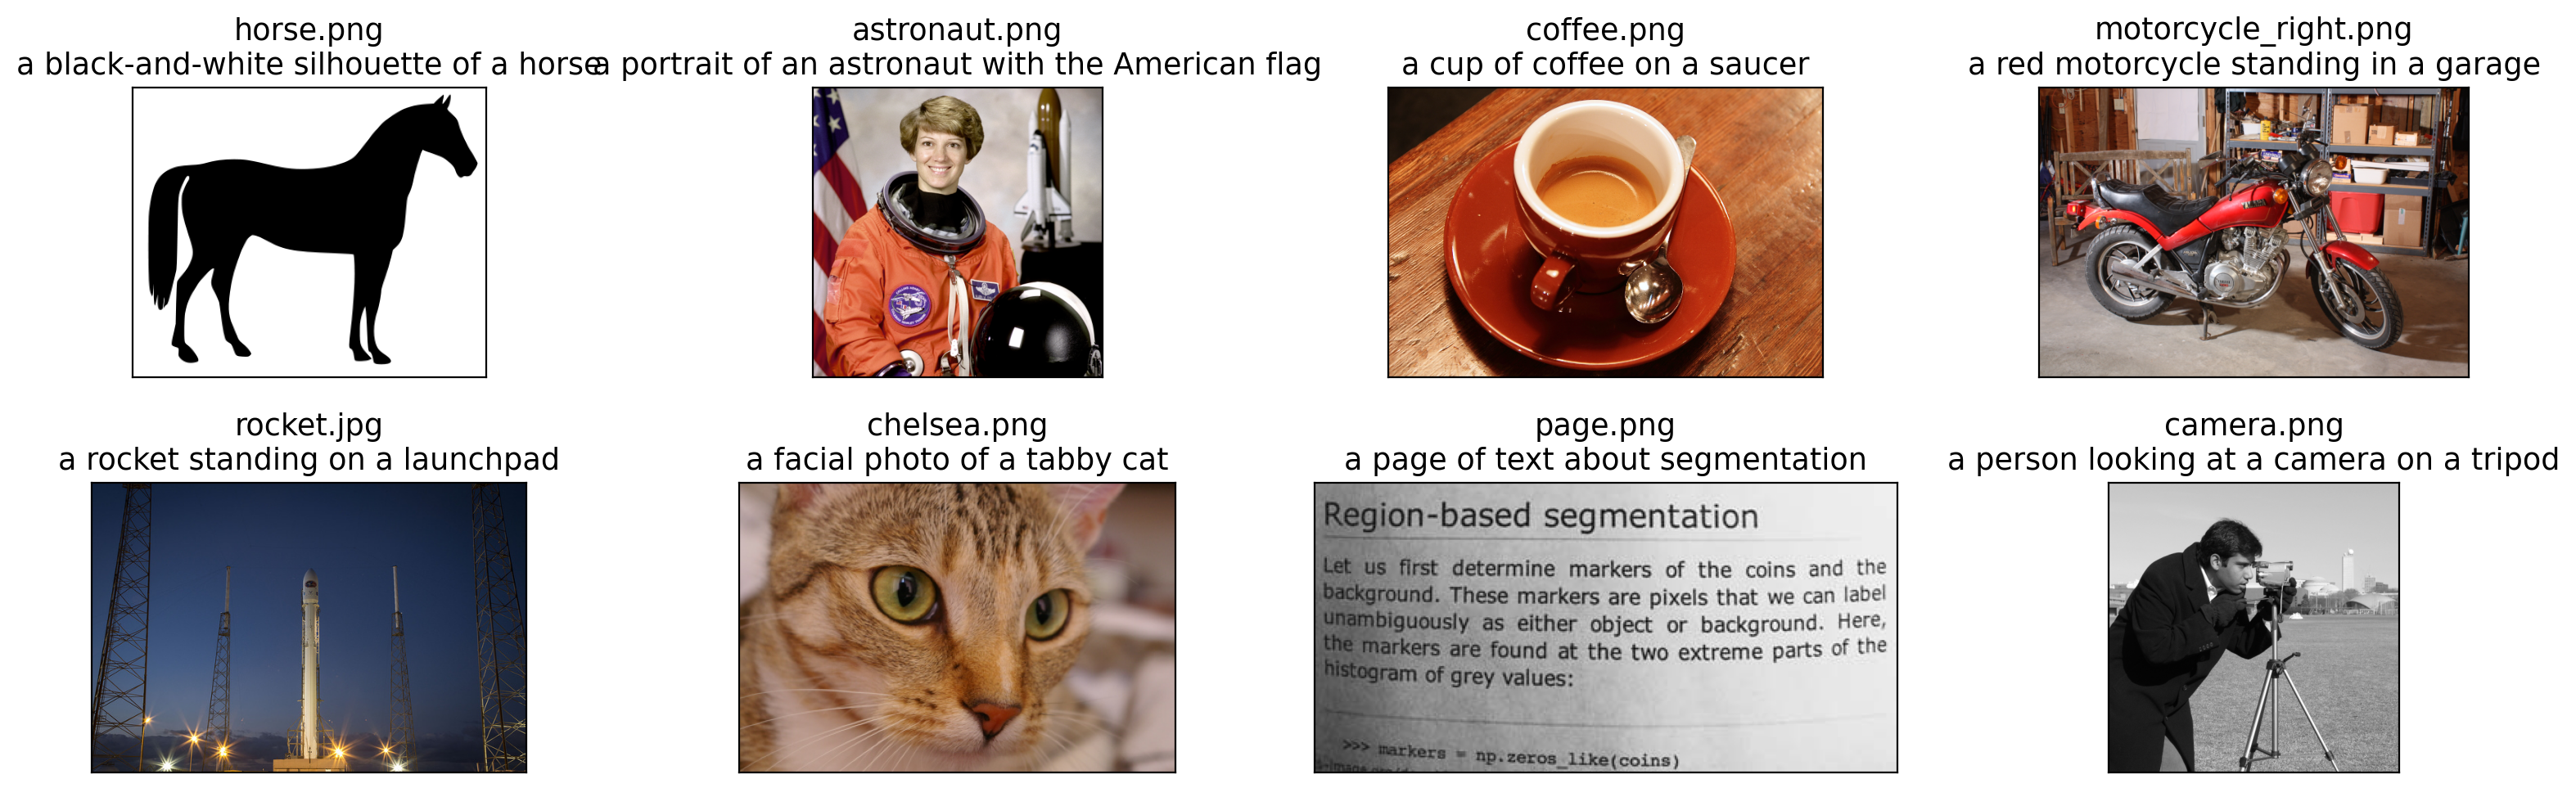

In [51]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()

In [54]:
image_input = torch.tensor(np.stack(images))
text_tokens = clip.tokenize(["This is " + desc for desc in texts])

In [55]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [56]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

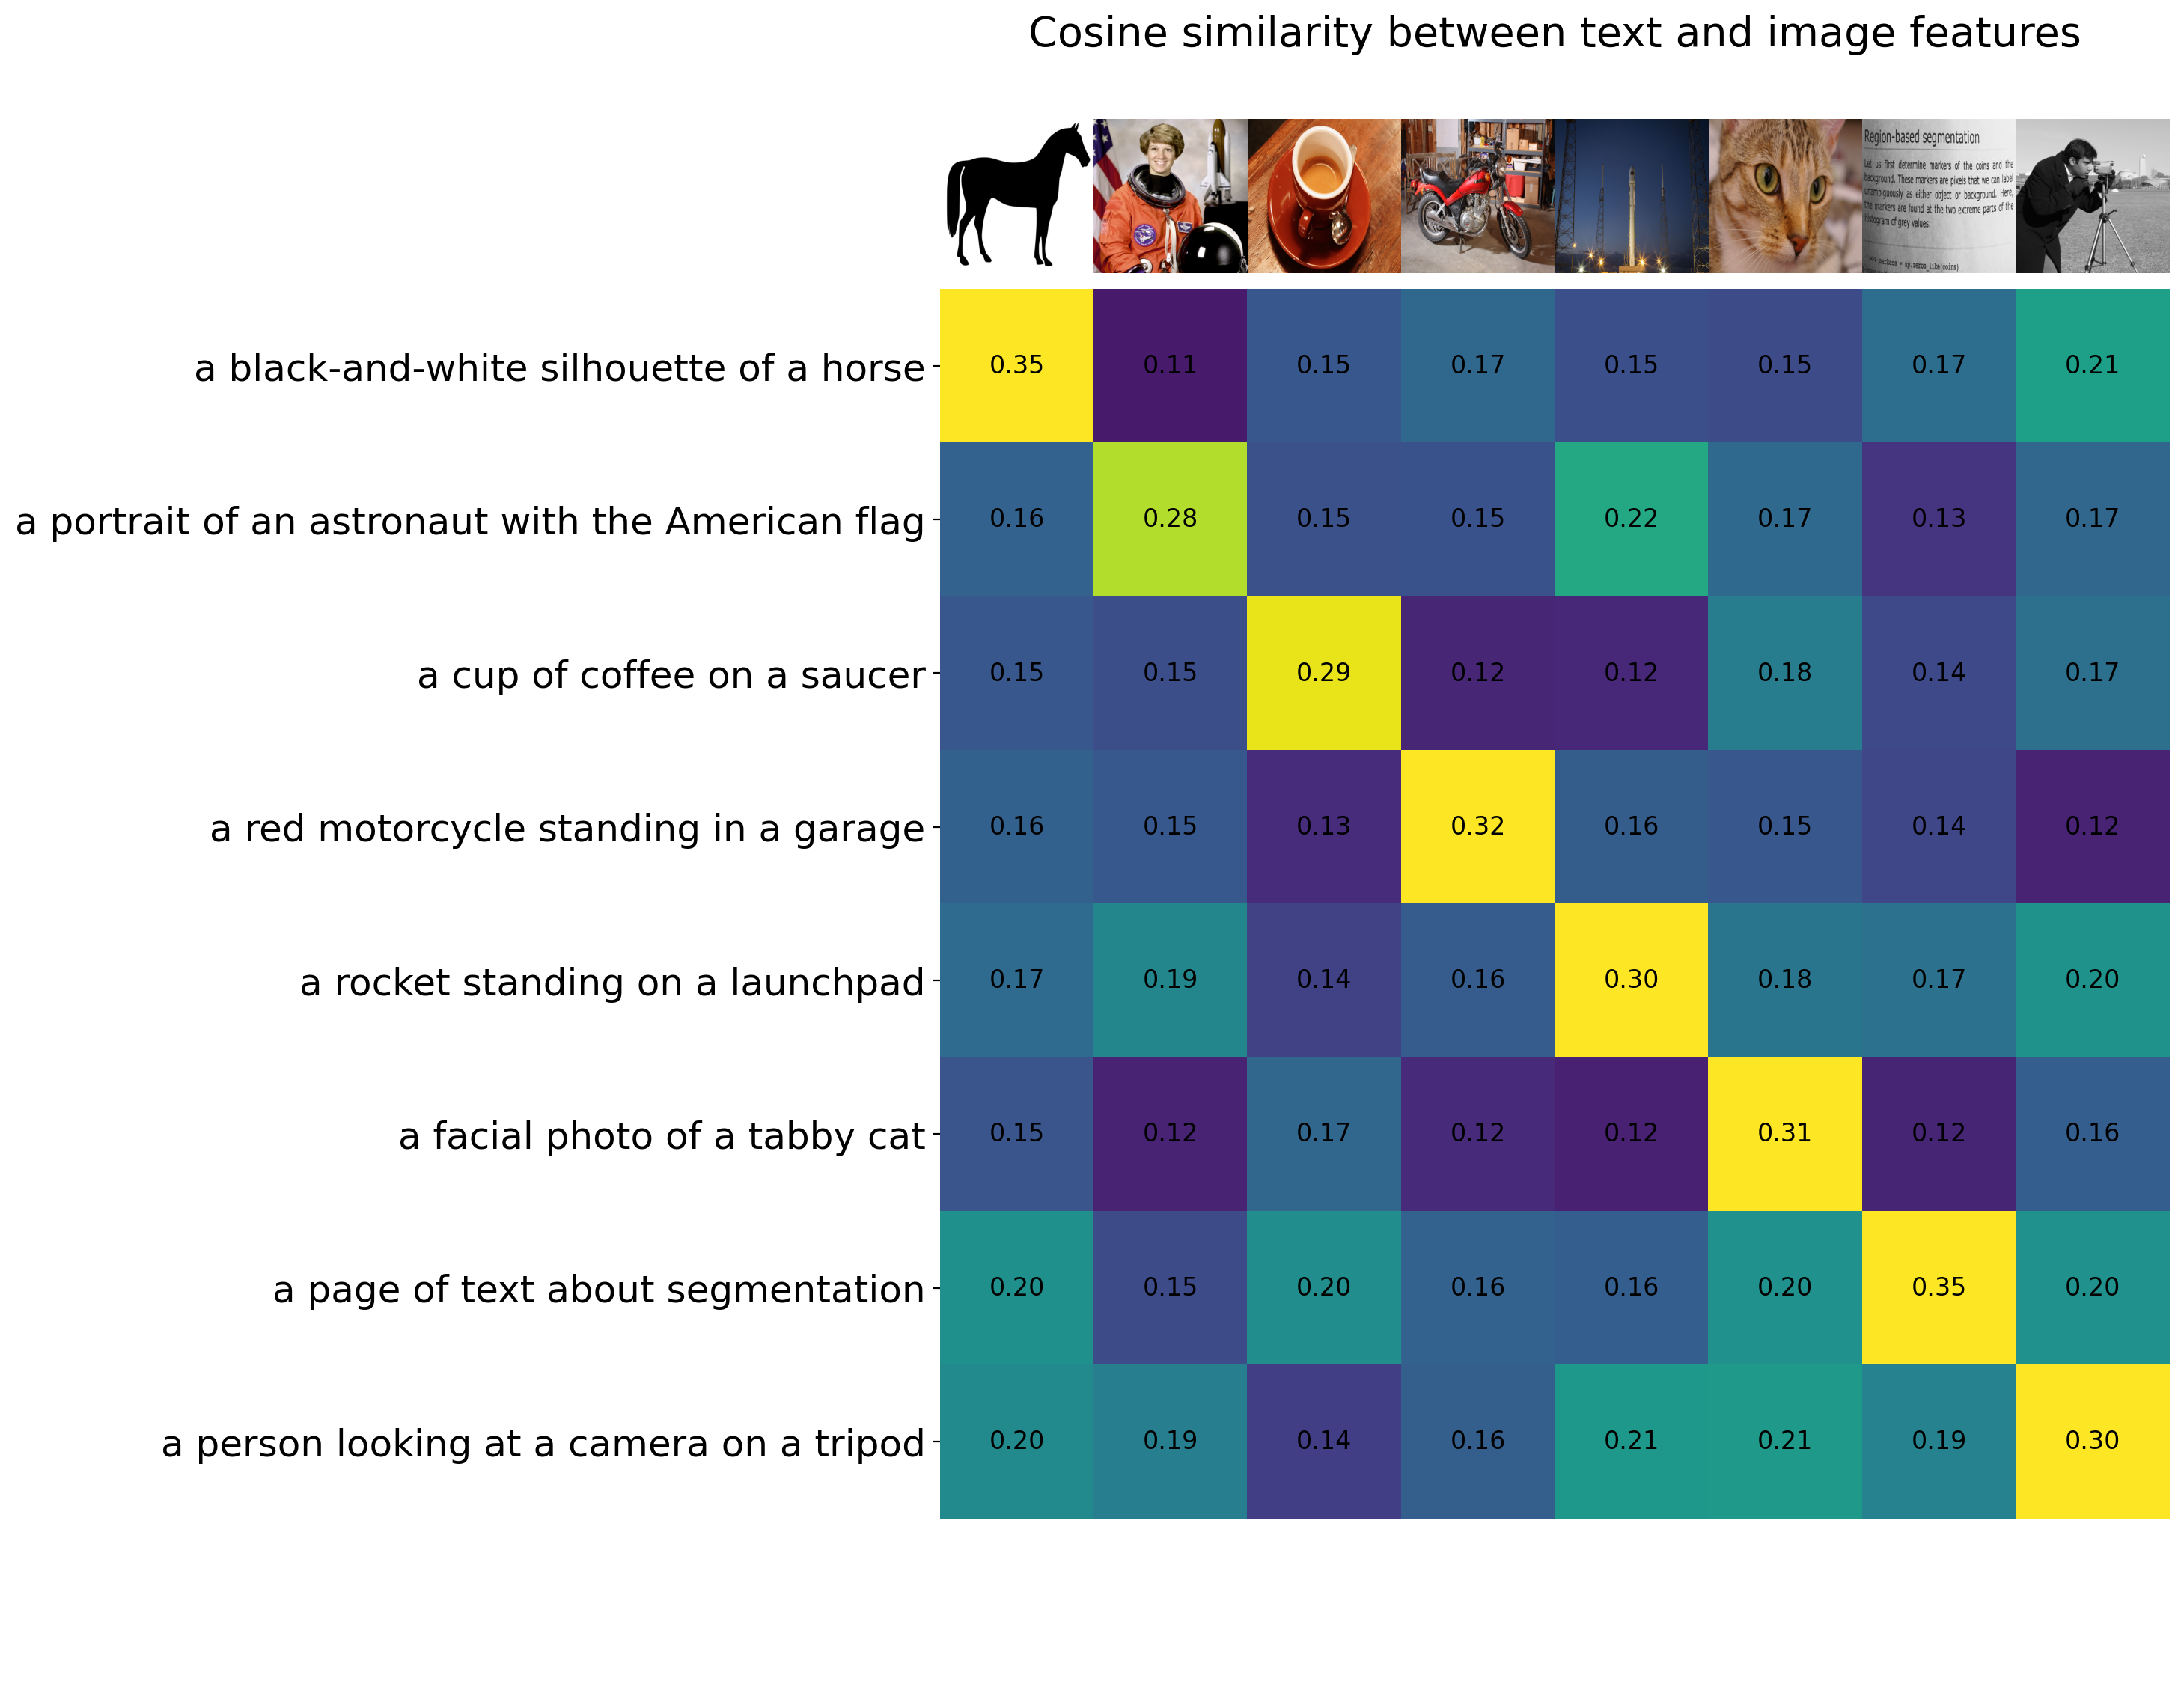

In [57]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

## Baseline

In [58]:
import clip

#pass image into yolo
data = Coco(local_annotations+"instances.json", local_annotations+"refs(umd).p")
yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
image, sentence = data[0]

yolo_output = yolo(local_path+image)

clip, preprocess = clip.load("ViT-B/32")

#pass each bounding box segmented image into clip with the sentence
clip_output = []
for i in range(len(yolo_output.xyxy[0])):
    x1 = yolo_output.xyxy[0][i][0].numpy()
    x1 = np.rint(x1)
    y1 = yolo_output.xyxy[0][i][1].numpy()
    y1 = np.rint(y1)
    x2 = yolo_output.xyxy[0][i][2].numpy()
    x2 = np.rint(x2)
    y2 = yolo_output.xyxy[0][i][3].numpy()
    y2 = np.rint(y2)
    print(x1, y1, x2, y2)
    img = Image.open(local_path+image)
    img = img.crop((x1, y1, x2, y2))
    img = preprocess(img)
    with torch.no_grad():
      img_features = clip.encode_image(img).float()
      text_features = clip.encode_text(clip.tokenize(sentence)).float()

    img_features /= img_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ img_features.cpu().numpy().T
    clip_output.append(similarity)

#visualize the results
plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)


Using cache found in /Users/pappol/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-4-8 Python-3.10.6 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


377.0 67.0 511.0 263.0


RuntimeError: The size of tensor a (768) must match the size of tensor b (7) at non-singleton dimension 2